In [1]:
import sys

sys.path.insert(0, '../src')

from pysycomp import *

import matplotlib.pyplot as plt
import numpy as np

# The Morse Potential

For this first module, we will be looking at a morse potential.

### 1. The Potential

We first must define the potential along with its parameters, as described below for the O-H stretch in a water molecule.

**Parameters**

$D = 4.419 eV$

$\alpha = 2.567 A^{(-1)}$

$q_0 = 0 A$




**Potential**

$V(q) = D*(1-e^{-\alpha(q-q_0)})^2$

We can define this potential as `potential`, and define the given parameters as `D`, `alpha`, and `q_0` as described below. We will also need to define the dependent variable, in this case `q` as a range using the `linspace` function found in `numpy`. The parameters are all in *atomic units*.

In [2]:
D = 4.419 
D1 = 1
D2 = 10 
alpha = 2.567 # Angstrom(-1) 
q_0 = 0 # Angstrom
q = np.linspace(-10, 10, 1000) # Angstrom

potential = D * (1 - np.exp(-alpha*(q-q_0)))**2
potential1 = D1 * (1 - np.exp(-alpha*(q-q_0)))**2
potential2 = D2 * (1 - np.exp(-alpha*(q-q_0)))**2

# Above values given in QHD paper for water O-H stretch

Now that the parameters and potential have been defined, the potential can be plotted using the `matplotlib.pyplot` library. Any of the lines can be changed as desired.

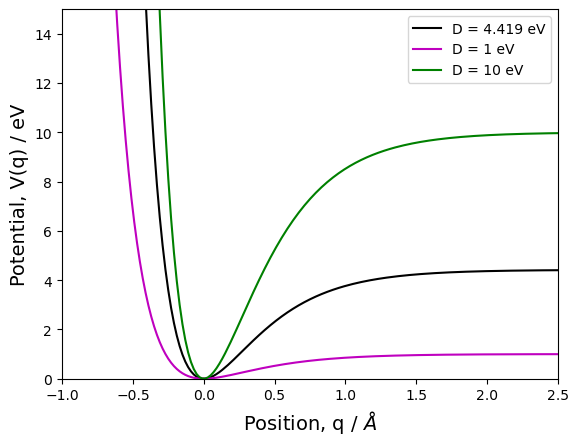

In [3]:
plt.plot(q, potential, 'k')
plt.plot(q, potential1, 'm')
plt.plot(q, potential2, "g")
plt.legend(["D = 4.419 eV", "D = 1 eV", "D = 10 eV"])

plt.ylim(0, 15) # (Lower, Upper) limit of the y-axis
plt.ylabel("Potential, V(q) / eV", fontsize=14) 
plt.xlim(-1, 2.5) # (Lower, Upper) limit of the x-axis
plt.xlabel("Position, q / $\AA$", fontsize=14)
plt.savefig('morse_vVq.png') # Save to this file name, as a png file
plt.show()

### 2. Derivation of  QHD formulas

Here, we use the pysces library, able to derive the equations of motion in the QHD method. We will need to define the `q`, `p`, `p2`, `x`, `x2`, and `xp` variables. In order to do this, we must first calculate the first and second derivatives of the potential of interest, defined in section 1. We will also use a change of variables as well, described below.

**2.1 The First and Second Derivatives of the Potential**

To take the derivatives, we must represent the potential symbolically. This can be done by:

In [4]:
# First, we must define all the parameters as stated in section 1 as symbols:

D, alpha, q = symbols("D, alpha, q")
q_0 = 0.0

# When computing symbolically, we do not need to use the numpy exponential function.

potential_sym = D * (1 - exp(-alpha*(q-q_0)))**2

Now that the potential is represented symbolically, we may take the first and second derivatives, described by `diff1` and `diff2`, respectively. Here you can use the `diff` function, which is found in the `sympy` library. This fuction takes the derivative symbolically with respect to the variable of interest, in this case `q`.

In [5]:
diff1 = diff(potential_sym, q)
diff2 = diff(diff1, q)

diff1, diff2

**2.2 Change of Variable**

We can now perform a change of variables, using `x` to represent the exponential term:

$$x=e^{-\alpha q}$$

And so:

$$V(q)=D[x^2-2x]$$

We will now take the first and second derivatives of the original potential, and then perform the change of variables.

- The First Derivative:

In [6]:
x = Symbol("x")

diff11 = diff1.replace(exp(-alpha*(q-q_0)), x).replace(exp(-2*alpha*(q-q_0)), x**2)

diff11

- The Second Derivative:

In [7]:
diff22 = diff2.replace(exp(-alpha*(q-q_0)), x).replace(exp(-2*alpha*(q-q_0)), x**2)

diff22

By performing this change of variables, it makes solving for the equations of motion simpler. We can now solve for the equations of motion, using the new variable `x`.

**2.3 Solving for the Equations of Motion**

We must solve the equations of motion for `q`, `p`, `x`, `x2`, and `xp` using the parameters defined in section 1.

In [8]:
# Again, we must first define all variables as symbols. #

q, p, p2, x, x2, xp, dt, mass, D, alpha = symbols("q, p, p2, x, x2, xp, dt, mass, D, alpha")
q_0 = 0.0

alp = alpha


########## EOM Calculations ##########

px = xp
q1 = str(time_deriv(q, 1)*dt + q)
print("q = " + str(q1))

x = exp(-alpha*q)
x1 = sympify(str(time_deriv(x, 1)).replace("exp(-alpha*q)", "x"))
x1 = str((symmetrize(x1))*(0.5)*dt + Symbol("x"))
print("x = " + str(x1))

p1 = str(time_deriv(p, 1)).replace("v(q)", str(potential_sym))
p1 = expand(sympify(p1).doit())
p1 = str(p1).replace("exp(-2*alpha*q)", "x2")
p1 = sympify(p1)
p1 = str(symmetrize(p1)*(0.5)*dt + p).replace("exp(-alpha*q)", "x")
print("p = " + str(p1))

x = Symbol("x")
p21 = str(time_deriv(p, 2)).replace("v(q)", str(potential_sym))
p21 = expand(sympify(p21).doit())
p21 = str(p21).replace("exp(-alpha*q)", "x").replace("exp(-2*alpha*q)", "x2").replace("alpha**2", "0")
p21 = str(symmetrize(p21)*(0.5)*dt + p2).replace("exp(-alpha*q)", "x").replace("exp(-2*alpha*q)", "x2")
print("p2 = " + str(p21))

### Please note these last two need to be in functions to work properly.

def integrate_x2(q,p,p2,x,x2,xp,dt,mass,alp,D):
    x2 = x2 - 4.0*(alpha/mass)*x*(xp - x*p)*0.5*dt
    x2 = exp(-2.0*alpha*p*dt/mass)*x2
    x2 = x2 - 4.0*(alpha/mass)*x*(xp - x*p)*0.5*dt
    return x2
print("x2 = " + str(integrate_x2(q,p,p2,x,x2,xp,dt,mass,alp,D)))

def integrate_xp(q,p,p2,x,x2,xp,dt,mass,alp,D):
    xp = xp + 0.5*dt*(2.0*alpha*D*(x*(3.0*x2 - 2*x*x) - x2)  - (alpha*x/mass)*(p2 - 2.0*p*p) )
    xp = exp(-2.0*alpha*p*dt/mass)*xp
    xp = xp + 0.5*dt*(2.0*alpha*D*(x*(3.0*x2 - 2*x*x) - x2)  - (alpha*x/mass)*(p2 - 2.0*p*p) )
    return xp
print("xp = " + str(integrate_xp(q,p,p2,x,x2,xp,dt,mass,alp,D)))

q = dt*p/mass + q
x = -0.5*alpha*dt*xp/mass + x
p = dt*(1.0*D*alpha*x2 - 1.0*D*alpha*x) + p
p2 = dt*(-2.0*D*alpha*xp + 2.0*D*alpha*(-2*p*x**2 + p*x2 + 2*x*xp)) + p2
x2 = -2.0*alpha*dt*x*(-p*x + xp)/mass + (-2.0*alpha*dt*x*(-p*x + xp)/mass + x2)*exp(-2.0*alpha*dt*p/mass)
xp = 0.5*dt*(2.0*D*alpha*(x*(-2*x**2 + 3.0*x2) - x2) - alpha*x*(-2.0*p**2 + p2)/mass) + (0.5*dt*(2.0*D*alpha*(x*(-2*x**2 + 3.0*x2) - x2) - alpha*x*(-2.0*p**2 + p2)/mass) + xp)*exp(-2.0*alpha*dt*p/mass)


Now, we are ready to make plots of the data based on the EOM's as computed above.

# 3. Graphing

**3.1 Generating Time-Dependent Values**

We will first define all of the parameters necessary to perform the QHD calculations. The below parameters are defined as followed:

`hbar`: Plancks constant

`convert`: A conversion factor for the mass

`mass`: The mass of the particle in the potential. In this case, the mass of a hydrogen atom is used.

`q0`: The starting position value

`p0`: The starting momentum value

`s0`: The mean width

`ps0`: The mean width momentum

`alp` (`alpha`): A constant in the morse potential

`D`: A constant in the morse potential

`dt`: The time step used

In [9]:
##### Constants #####

hbar = 0.6582  # eV * fs
convert = (1.0/17.586)

# Feel free to change any of the below parameters to observe what happens when you change them
mass = 2980.0*convert
q0 = 0.15
p0 = 0.0
s0 = 0.05
ps0 = 0.0
alp = 2.567
alpha = alp

dt = 0.1
D = 4.419

**Q1.** Qualitatively, how does the `D` value affect the potential? The `alpha` value?

Below, the initial conditions are described. These initial conditions describe a gaussian wavepacket, and do not need to be changed.

In [10]:
##### Initial Conditions (Do Not Change) #####

t = 0.0    
Etot = 0.0
Etot0 = 0.0
Etot_cl = 0.0
Etot_cl0 = 0.0
q,p,pq,q2,p2,x,x2,xp,xq = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
q, p = q0, p0
q_0 = 0.0
q2 = q*q + s0*s0
pq = ps0*s0 + q*p
p2 = p*p + ps0*ps0 + (0.5*hbar/s0)**2
x = math.exp(-alp*q0)*math.exp(0.5*alp*alp*s0*s0)
x2 = math.exp(-2.0*alp*q0)*math.exp(2.0*alp*alp*s0*s0)
xq = x*(q-alp*s0*s0)
xp = x*(p - s0*ps0*alp)

xp = integrate_xp(q,p,p2,x,x2,xp,0.5*dt,mass,alp,D)
x2 = integrate_x2(q,p,p2,x,x2,xp,0.5*dt,mass,alp,D)
x = eval(x1)
p2 = eval(p21)
p = eval(p1)
q = eval(q1)
p = eval(p1)
p2 = eval(p21)
x = eval(x1)
x2 = integrate_x2(q,p,p2,x,x2,xp,0.5*dt,mass,alp,D)
xp = integrate_xp(q,p,p2,x,x2,xp,0.5*dt,mass,alp,D)

Below, empty lists are created to store the data generated. Feel free to create your own lists to examine how different variables change over time.

In [11]:
##### Empty Lists for Data Storage: #####

q_list = [] 
p_list = []

**Q2.** Create an empty list for `p2` values and observe how this variable changes over time.

Now that the parameters have been defined, we can compute the desired values of position and momentum over a given time interval.

**Q3.** Try changing the time step (`dt`) or the finish time (`t_f`).

In [12]:
### Time how long it takes to compute ###

import time 
begin = time.time()


### Compute the x values ###

dt = 0.1 # step size
t_i = 0.0 # start
t_f = 1000 # finish

#### --- Do Not Change Anything Below --- #####

### Compute the y values ###

while t_i<=t_f:
    xp = integrate_xp(q,p,p2,x,x2,xp,0.5*dt,mass,alp,D)
    x2 = integrate_x2(q,p,p2,x,x2,xp,0.5*dt,mass,alp,D)
    x = eval(x1)
    p2 = eval(p21)
    p = eval(p1)
    q = eval(q1)
    p = eval(p1)
    p2 = eval(p21)
    x = eval(x1)
    x2 = integrate_x2(q,p,p2,x,x2,xp,0.5*dt,mass,alp,D)
    xp = integrate_xp(q,p,p2,x,x2,xp,0.5*dt,mass,alp,D)

    t_i = t_i + dt

##### --- #####

    # Here is where you add the lists to store data
    
    q_list.append(q)
    p_list.append(p)
        
### Compute the end time ###
    
time.sleep(1)
# store end time
end = time.time()
  
# total time taken
print(f"Total runtime is {end - begin}")

Total runtime is 45.760335206985474


For the x values, we create a range with `(t_i, t_f, dt)` as the parameters. Due to the increasing nature of `t_i`, the initial value of `0.0` is used in its place.

In [13]:
### Define the x values ###

x_list = np.arange(0.0, t_f, dt)

**3.2 Graphing Position versus Time**

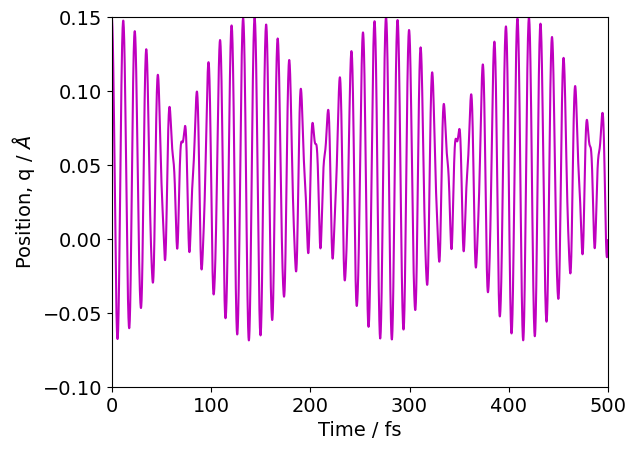

In [14]:
plt.plot(x_list, q_list, 'm')
plt.xlim(0, 500)
plt.xlabel("Time / fs", fontsize=14)
plt.ylabel("Position, q / $\AA$", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.10, 0.15)
#plt.savefig("morse_qvt.png")
plt.show()

**3.3 Graphing Momentum versus Time**

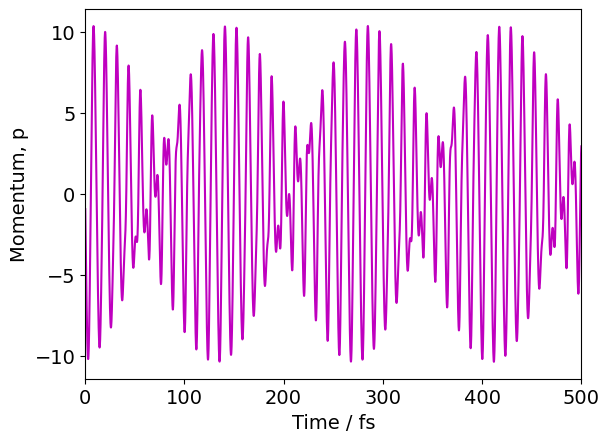

In [15]:
plt.plot(x_list, p_list, 'm')
plt.xlim(0, 500)
plt.xlabel("Time / fs", fontsize=14)
plt.ylabel("Momentum, p", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("morse_pvt.png")
plt.show()

**Q4.** How does increasing `D` to `10` affect the position and momentum? What about decreasing to `1`?

# 4. Comparing to Classical Equations of Motion

Here, you will compare classical equations of motion to the QHD equations of motion as described in the previous sections. In order to do this, we must repeat some of the above codes.

In [16]:
# Again, we must first define all variables as symbols. #

q, p, p2, x, x2, xp, dt, mass, D, alpha = symbols("q, p, p2, x, x2, xp, dt, mass, D, alpha")
q_0 = 0.0

########## Classical EOM Calculations ##########

px = xp
q1 = str(time_deriv(q, 1)*dt + q)
print("q = " + str(q1))


p1 = str(time_deriv(p, 1)).replace("v(q)", str(potential_sym))
p1 = expand(sympify(p1).doit())
p1 = str(p1)
p1 = sympify(p1)
p1 = str(symmetrize(p1)*(0.5)*dt + p)
print("p = " + str(p1))

p21 = str(time_deriv(p, 2)).replace("v(q)", str(potential_sym))
p21 = expand(sympify(p21).doit())
p21 = str(-p21)
p21 = str(symmetrize(p21)*(0.5)*dt + p2)
print("p2 = " + str(p21))

q = dt*p/mass + q
p = dt*(-1.0*D*alpha*exp(-alpha*q) + 1.0*D*alpha*exp(-2*alpha*q)) + p
p2 = dt*(2.0*D*alpha*p*exp(-alpha*q) - 2.0*D*alpha*p*exp(-2*alpha*q)) + p2


In [17]:
##### Constants #####

hbar = 0.6582  # eV * fs
convert = (1.0/17.586)

# Feel free to change any of the below parameters to observe what happens when you change them
mass = 2980.0*convert
q0 = 0.15
p0 = 0.0
s0 = 0.05
ps0 = 0.0

alp = 2.567
alpha = alp
dt = 0.1 # Step size
D = 4.417

In [18]:
##### Initial Conditions (Do Not Change) #####

t = 0.0    
Etot = 0.0
Etot0 = 0.0
Etot_cl = 0.0
Etot_cl0 = 0.0
q,p,pq,q2,p2,x,x2,xp,xq = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
q, p = q0, p0
q_0 = 0.0
q2 = q*q + s0*s0
pq = ps0*s0 + q*p
p2 = p*p + ps0*ps0 + (0.5*hbar/s0)**2
x = math.exp(-alp*q0)*math.exp(0.5*alp*alp*s0*s0)
x2 = math.exp(-2.0*alp*q0)*math.exp(2.0*alp*alp*s0*s0)
xq = x*(q-alp*s0*s0)
xp = x*(p - s0*ps0*alp)

p2 = eval(p21)
p = eval(p1)
q = eval(q1)
p = eval(p1)
p2 = eval(p21)

In [19]:
##### Empty Lists for Data Storage: #####

q_list_classical = [] 
p_list_classical = []

In [20]:
### Time how long it takes to compute ###

import time 
begin = time.time()


### Compute the x values ###

t_i = 0.0 # start
t_f = 1000 # finish


### Compute the y values ###

while t_i<=t_f:

    p2 = eval(p21)

    p = eval(p1)

    q = eval(q1)

    p = eval(p1)

    p2 = eval(p21)


    t_i = t_i + dt
        
    # Here is where you add the lists to store data
    q_list_classical.append(q)
    p_list_classical.append(p)


### Compute the end time ###
    
time.sleep(1)
# store end time
end = time.time()
  
# total time taken
print(f"Total runtime is {end - begin}")

Total runtime is 20.276559591293335


In [21]:
### Define the x values ###

x_list = np.arange(0, t_f, dt)

We can now plot the classical position and the QHD position on the same graph

**Q5.** Predict qualitatively what the classical motion will look like.

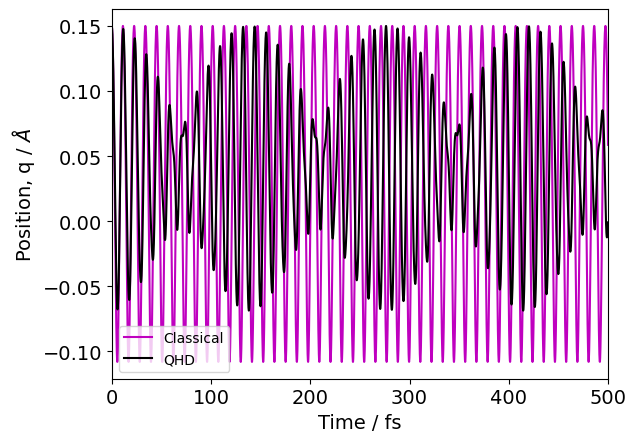

In [22]:
plt.plot(x_list, q_list_classical, 'm')
plt.plot(x_list, q_list, "k")
plt.legend(["Classical", "QHD"])
plt.xlim(0, 500)
plt.xlabel("Time / fs", fontsize=14)
plt.ylabel("Position, q / $\AA$", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("morse_classical_comparison_qvt.png")
plt.show()

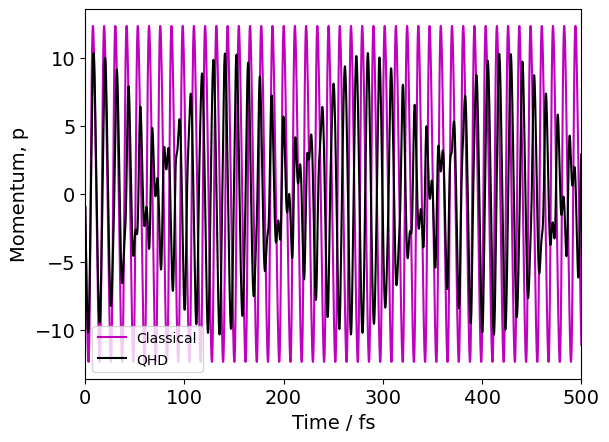

In [23]:
plt.plot(x_list, p_list_classical, 'm')
plt.plot(x_list, p_list, "k")
plt.legend(["Classical", "QHD"])
plt.xlim(0, 500)
plt.xlabel("Time / fs", fontsize=14)
plt.ylabel("Momentum, p", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("morse_classical_comparison_pvt.png")
plt.show()